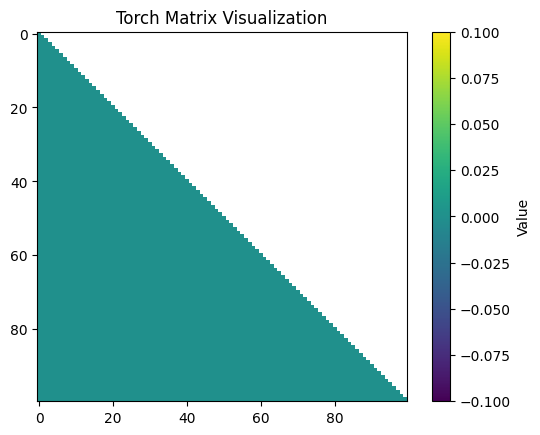

Input shape: torch.Size([10])
Output shape: torch.Size([10, 10000])


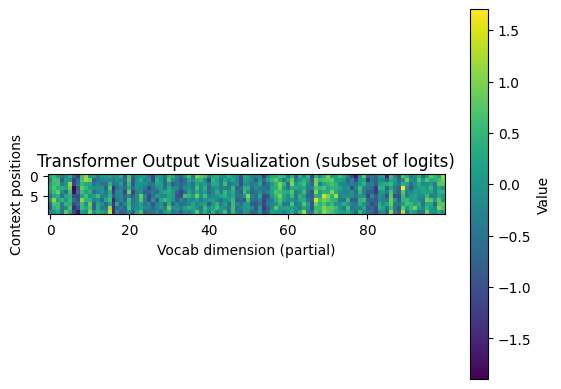

Attention head output shape: torch.Size([10, 128])


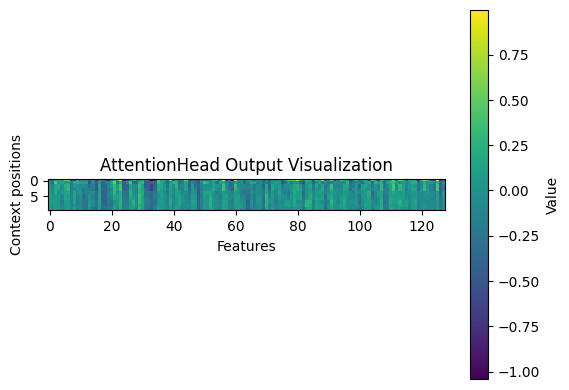

Getting book 84...
	426785 characters read
Getting book 85...
	359291 characters read


Token indices sequence length is longer than the specified maximum sequence length for this model (202757 > 1024). Running this sequence through the model will result in indexing errors


Input_ids shape: torch.Size([2027, 100])
Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000020322A1A810>
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
Epoch 1, Step 10, Loss: 10.2985
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
Epoch 1, Step 20, Loss: 10.0184
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
Epoch 1, Step 30, Loss: 9.8188
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
Epoch 1, Step 40, Loss: 9.5553
cuda:0


KeyboardInterrupt: 

In [3]:
#!/usr/bin/env python
# coding: utf-8

"""
transformer_rmsnorm_gelu.py

Single Python script that:
  1) Implements a Transformer with:
     - Learned positional embeddings
     - RMSNorm layers
     - GELU activation in the MLP
  2) Downloads Gutenberg books
  3) Tokenizes data and trains the Transformer
"""

import math
import requests
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer

###############################################################################
# RMSNorm Implementation
###############################################################################

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Compute RMS norm over the last dimension
        # x: [n_context, d_model]
        norm = x.pow(2).mean(-1, keepdim=True).sqrt()  # RMS across last dimension
        return self.weight * x / (norm + self.eps)

###############################################################################
# Causal Mask Creation
###############################################################################

def create_mask(n_context: int) -> torch.Tensor:
    """
    Creates an upper-triangular mask (causal mask) of shape (n_context, n_context)
    where positions cannot attend to subsequent positions.
    """
    mask = torch.zeros(n_context, n_context)
    # indices above the main diagonal
    indices = torch.triu_indices(n_context, n_context, offset=1)
    mask[indices[0], indices[1]] = float('-inf')
    return mask

# Optional: visualize the mask (comment out if not needed)
if __name__ == "__main__":
    M = create_mask(100)
    plt.imshow(M.numpy(), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Torch Matrix Visualization')
    plt.show()

###############################################################################
# Configuration Dataclass
###############################################################################

@dataclass
class GPTConfig:
    d_vocab: int = 10_000
    d_model: int = 128
    d_mlp: int = 512
    n_heads: int = 4
    d_head: int = 32
    n_layers: int = 6
    # Use GELU here
    act_fn: type = nn.GELU  
    n_ctx: int = 512  # maximum sequence length for positional embeddings

###############################################################################
# AttentionHead
###############################################################################

class AttentionHead(nn.Module):
    """
    Single attention head for the Transformer.
    """

    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.W_Q = nn.Linear(cfg.d_model, cfg.d_head)
        self.W_K = nn.Linear(cfg.d_model, cfg.d_head)
        self.W_V = nn.Linear(cfg.d_model, cfg.d_head)
        self.W_O = nn.Linear(cfg.d_head, cfg.d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [n_context, d_model]
        Returns: [n_context, d_model]
        """
        n_context = x.size(0)
        Q = self.W_Q(x)  # [n_context, d_head]
        K = self.W_K(x)  # [n_context, d_head]
        V = self.W_V(x)  # [n_context, d_head]

        # Scaled dot-product attention
        M = create_mask(n_context).to(x.device)  # [n_context, n_context]
        scores = (Q @ K.T) / math.sqrt(Q.size(-1))  # [n_context, n_context]
        scores = scores + M
        A = F.softmax(scores, dim=-1)  # [n_context, n_context]
        head_output = A @ V  # [n_context, d_head]

        return self.W_O(head_output)  # [n_context, d_model]

###############################################################################
# MultiHeadedAttention
###############################################################################

class MultiHeadedAttention(nn.Module):
    """
    Applies multiple attention heads and sums their outputs.
    """

    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.cfg = cfg
        self.heads = nn.ModuleList([AttentionHead(cfg) for _ in range(cfg.n_heads)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [n_context, d_model]
        Returns: [n_context, d_model]
        """
        out = 0
        for head in self.heads:
            out = out + head(x)
        return out

###############################################################################
# MLP
###############################################################################

class MLP(nn.Module):
    """
    Feed-forward block for each Transformer layer.
    """

    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.hidden = nn.Linear(cfg.d_model, cfg.d_mlp)
        self.output = nn.Linear(cfg.d_mlp, cfg.d_model)
        # Use the activation function specified in cfg (now GELU)
        self.act = cfg.act_fn()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [n_context, d_model]
        Returns: [n_context, d_model]
        """
        return self.output(self.act(self.hidden(x)))

###############################################################################
# Transformer
###############################################################################

class Transformer(nn.Module):
    """
    A simple GPT-style Transformer with:
    - Learned token embeddings
    - Learned positional embeddings
    - RMSNorm
    - GELU in the MLP
    """

    def __init__(self, cfg: GPTConfig):
        super().__init__()
        self.cfg = cfg

        # Token embedding
        self.embedding = nn.Embedding(cfg.d_vocab, cfg.d_model)

        # Learned positional embeddings
        self.pos_embedding = nn.Embedding(cfg.n_ctx, cfg.d_model)

        # Unembedding layer
        self.unembedding = nn.Linear(cfg.d_model, cfg.d_vocab)

        # Transformer layers
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'attn': MultiHeadedAttention(cfg),
                'norm1': RMSNorm(cfg.d_model),
                'mlp': MLP(cfg),
                'norm2': RMSNorm(cfg.d_model)
            })
            for _ in range(cfg.n_layers)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [n_context] (token IDs)
        Returns: [n_context, d_vocab] (logits)
        """
        # Token embeddings
        x = self.embedding(x)  # [n_context, d_model]

        # Positional embeddings
        positions = torch.arange(x.size(0), device=x.device)
        pos_embeds = self.pos_embedding(positions)
        x = x + pos_embeds

        # Transformer layers
        for layer in self.layers:
            # Multi-head attention
            x = x + layer['attn'](x)
            x = layer['norm1'](x)

            # MLP
            x = x + layer['mlp'](x)
            x = layer['norm2'](x)

        # Final unembedding to produce logits
        return self.unembedding(x)

###############################################################################
# Gutenberg Book Utilities (get_gutenberg_book, get_many_books)
###############################################################################

def get_gutenberg_book(
    id: int = 84,
    data_temp: Path | str = "./data/gutenberg_data",
    remove_gutenberg_meta: bool = True
) -> str:
    """
    Download a book from Project Gutenberg or load from cache.
    """
    data_temp = Path(data_temp)
    data_temp.mkdir(parents=True, exist_ok=True)

    url: str = f"https://www.gutenberg.org/cache/epub/{id}/pg{id}.txt"
    data_path: Path = data_temp / f"{id}.txt"

    if data_path.exists():
        with open(data_path, "r", encoding="utf-8") as file:
            data = file.read()
    else:
        response = requests.get(url)
        response.raise_for_status()
        data = response.text
        with open(data_path, "w", encoding="utf-8") as file:
            file.write(data)

    if remove_gutenberg_meta:
        # remove header/footer
        data = '***'.join(data.split('***')[2:])
        data = '***'.join(data.split('***')[:-1])

    return data

def get_many_books(
    ids: list[int],
    data_temp: Path | str = "./data/gutenberg_data"
) -> list[str]:
    """
    Download multiple Gutenberg books or load from cache.
    """
    data = []
    for book_id in ids:
        print(f"Getting book {book_id}...")
        text = get_gutenberg_book(book_id, data_temp)
        print(f"\t{len(text)} characters read")
        data.append(text)
    return data

###############################################################################
# Main / Example Usage
###############################################################################

if __name__ == "__main__":

    # 1. Test basic Transformer shape
    cfg = GPTConfig()
    transform = Transformer(cfg)

    n_context = 10
    x = torch.randint(0, cfg.d_vocab, (n_context,))
    print("Input shape:", x.shape)
    output = transform(x)
    print("Output shape:", output.shape)

    # Optional: visualize a subset of output
    plt.imshow(output.detach().numpy()[:, :100], cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title("Transformer Output Visualization (subset of logits)")
    plt.xlabel("Vocab dimension (partial)")
    plt.ylabel("Context positions")
    plt.show()

    # 2. Test AttentionHead separately
    ah = AttentionHead(cfg)
    test_x = torch.randn(10, cfg.d_model)
    print("Attention head output shape:", ah(test_x).shape)

    attn_out = ah(test_x)
    plt.imshow(attn_out.detach().numpy(), cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title("AttentionHead Output Visualization")
    plt.xlabel("Features")
    plt.ylabel("Context positions")
    plt.show()

    # 3. Training Setup
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    model_cfg = GPTConfig(
        d_model=128,
        d_vocab=tokenizer.vocab_size,
        n_heads=4,
        n_layers=6,
        d_mlp=512,
        n_ctx=512,
        act_fn=nn.GELU  # explicitly set to GELU
    )

    # Load some Gutenberg books
    book_ids = [84, 85]
    dataset_text = get_many_books(book_ids, data_temp="./data/gutenberg_data")

    rawtext = ""
    for book in dataset_text:
        rawtext += book

    tokens = tokenizer(rawtext, return_tensors="pt")

    # Prepare data: split tokens into chunks
    chunk_size = 100
    to_remove = tokens["input_ids"].shape[1] % chunk_size
    new_shape = tokens["input_ids"].shape[1] // chunk_size

    if to_remove > 0:
        attention_mask = tokens["attention_mask"][0][:-to_remove].reshape(new_shape, chunk_size)
        input_ids = tokens["input_ids"][0][:-to_remove].reshape(new_shape, chunk_size)
    else:
        attention_mask = tokens["attention_mask"][0].reshape(new_shape, chunk_size)
        input_ids = tokens["input_ids"][0].reshape(new_shape, chunk_size)

    dataset = TensorDataset(input_ids, attention_mask)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    print("Input_ids shape:", input_ids.shape)
    print("Dataloader:", dataloader)

    # Initialize model and training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Transformer(model_cfg).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    model.train()
    n_epochs = 2
    print_interval = 10

    print(model.pos_embedding.weight.device)

    for epoch in range(n_epochs):
        for step, batch in enumerate(dataloader):
            # batch[0]: [batch_size, seq_len]
            input_ids_batch = batch[0].to(device)
            total_loss = 0.0
            bs = input_ids_batch.size(0)

            print(input_ids_batch.device)

            # Process each sequence individually
            for i in range(bs):
                seq_ids = input_ids_batch[i]  # shape [seq_len]
                # Next-token prediction: input is all but last token, target is all but first
                inp = seq_ids[:-1]
                targ = seq_ids[1:]

                logits = model(inp)  # [seq_len-1, d_vocab]
                loss = criterion(logits, targ)
                total_loss += loss

            total_loss = total_loss / bs
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if (step + 1) % print_interval == 0:
                print(f"Epoch {epoch+1}, Step {step+1}, Loss: {total_loss.item():.4f}")
